# 📊 Credit Score Simulator – Data Cleaning, EDA & Feature Engineering

## 1. Problem Statement 🎯  
In today’s financial landscape, predicting the risk of serious delinquency is a critical challenge for credit institutions. Identifying high-risk individuals in advance helps prevent defaults and enables more responsible lending practices.  

The main objective of this project is to build a machine learning model that predicts whether a person will experience **serious delinquency (90+ days overdue)** within the next two years, using historical credit behavior data. Based on the model results, a **credit score simulator** will be developed to illustrate how variations in financial behavior influence an individual’s credit risk.



## 2. Hypothesis 💡  
It is hypothesized that certain financial behavior patterns—such as high credit utilization, a short credit history, and frequent late payments—are strong indicators of future serious delinquency.  

By analyzing these patterns, the project aims to identify the most influential variables for credit risk and simulate how changes in these variables can impact a person’s predicted score.


## 3. Dataset Overview 📂  
The dataset used in this project is **“Give Me Some Credit”**, publicly available on Kaggle. It contains anonymized credit behavior records for over 150,000 individuals.

The target variable is:

- `SeriousDlqin2yrs`: Indicates whether the person experienced serious delinquency (90+ days past due) in the following two years. (1 = Yes, 0 = No)

The dataset features include:

- `RevolvingUtilizationOfUnsecuredLines`: Total balance on credit cards and personal lines of credit relative to total credit limits.
- `age`: Age of the borrower in years.
- `NumberOfTime30-59DaysPastDueNotWorse`: Number of times the borrower was 30–59 days past due but not worse in the last 2 years.
- `DebtRatio`: Monthly debt payments, alimony, living costs divided by monthly gross income.
- `MonthlyIncome`: Monthly income of the borrower.
- `NumberOfOpenCreditLinesAndLoans`: Number of open loans and lines of credit (e.g., car loan or mortgage).
- `NumberOfTimes90DaysLate`: Number of times the borrower was 90 days or more past due.
- `NumberRealEstateLoansOrLines`: Number of real estate loans or lines, including mortgages.
- `NumberOfTime60-89DaysPastDueNotWorse`: Number of times the borrower was 60–89 days past due but not worse.
- `NumberOfDependents`: Number of dependents in the household.


## 4. Objective of This Notebook ⚙️  
This notebook covers the full **data preparation pipeline** to create a modeling-ready dataset. The following steps are included:

- Loading and inspecting the dataset
- Handling missing values and outliers
- Performing exploratory data analysis (EDA) to identify key patterns and predictors
- Creating new features through domain-informed engineering
- Exporting the final cleaned dataset for use in the modeling phase


# 5. Data Overview and Initial Inspection 🔍

## 5.1 Loading and Previewing the Dataset

The dataset is loaded from the original `cs-training.csv` file provided in the "Give Me Some Credit" competition. The first column, which contains unique identifiers, is used as the index for the DataFrame.

To improve readability and simplify analysis, several column names have been renamed. The new names aim to be shorter and more intuitive, especially for visualization and modeling purposes. The changes are as follows:

- `RevolvingUtilizationOfUnsecuredLines` → `RevolvingUtilization`
- `NumberOfTime30-59DaysPastDueNotWorse` → `Times30_59DaysLate`
- `DebtRatio` → `DebtToIncomeRatio`
- `NumberOfOpenCreditLinesAndLoans` → `OpenCreditLines`
- `NumberOfTimes90DaysLate` → `Times90DaysLate`
- `NumberRealEstateLoansOrLines` → `RealEstateLoans`
- `NumberOfTime60-89DaysPastDueNotWorse` → `Times60_89DaysLate`

A preview of the updated dataset is shown below.


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import KNNImputer, IterativeImputer

In [ ]:
# Set seaborn style for better visualizations
sns.set_theme(style="whitegrid")

# Load the dataset (adjust path if necessary)
df = pd.read_csv("../data/cs-training.csv", index_col=0)

# Rename columns for clarity
df.rename(columns={
    "RevolvingUtilizationOfUnsecuredLines": "RevolvingUtilization",
    "NumberOfTime30-59DaysPastDueNotWorse": "Times30_59DaysLate",
    "DebtRatio": "DebtToIncomeRatio",
    "NumberOfOpenCreditLinesAndLoans": "OpenCreditLines",
    "NumberOfTimes90DaysLate": "Times90DaysLate",
    "NumberRealEstateLoansOrLines": "RealEstateLoans",
    "NumberOfTime60-89DaysPastDueNotWorse": "Times60_89DaysLate"
}, inplace=True)

# Display first few rows to verify
df.head()


,SeriousDlqin2yrs,RevolvingUtilization,age,Times30_59DaysLate,DebtToIncomeRatio,MonthlyIncome,OpenCreditLines,Times90DaysLate,RealEstateLoans,Times60_89DaysLate,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   SeriousDlqin2yrs      150000 non-null  int64  
 1   RevolvingUtilization  150000 non-null  float64
 2   age                   150000 non-null  int64  
 3   Times30_59DaysLate    150000 non-null  int64  
 4   DebtToIncomeRatio     150000 non-null  float64
 5   MonthlyIncome         120269 non-null  float64
 6   OpenCreditLines       150000 non-null  int64  
 7   Times90DaysLate       150000 non-null  int64  
 8   RealEstateLoans       150000 non-null  int64  
 9   Times60_89DaysLate    150000 non-null  int64  
 10  NumberOfDependents    146076 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 13.7 MB


## 5.2 Dataset Info and Description

**📝 Output interpretation:**

- The dataset contains 150,000 entries and 11 features.
- The variables `MonthlyIncome` and `NumberOfDependents` contain missing values.
- All columns are numeric, so no encoding is required at this stage.


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilization,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
Times30_59DaysLate,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtToIncomeRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
OpenCreditLines,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
Times90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
RealEstateLoans,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
Times60_89DaysLate,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0


## 5.3 Summary Statistics

**📝 Output interpretation:**

- Several features contain values close to zero but exhibit extremely large maximums (e.g., `RevolvingUtilization` and `DebtToIncomeRatio`), suggesting the presence of significant outliers or data errors. 
- `MonthlyIncome` has a high standard deviation and a maximum value exceeding \$3 million, which may indicate data entry errors or extreme outlier cases.
- The delinquency-related variables (`Times30_59DaysLate`, `Times60_89DaysLate`, `Times90DaysLate`) contain unusually high values such as 98. These are likely placeholder codes representing missing or undefined data and should be further investigated and handled appropriately.


# 6. Data Cleaning and Preprocessing 🧹


## 6.1 Handling Missing Values

This section focuses on identifying and addressing missing values within the dataset.

The following steps will be conducted:
- Quantify the number and percentage of missing values per variable  
- Visualize the distributions of affected variables  
- Apply appropriate imputation strategies based on variable type and distribution characteristics


In [9]:
df.isnull().sum()

SeriousDlqin2yrs            0
RevolvingUtilization        0
age                         0
Times30_59DaysLate          0
DebtToIncomeRatio           0
MonthlyIncome           29731
OpenCreditLines             0
Times90DaysLate             0
RealEstateLoans             0
Times60_89DaysLate          0
NumberOfDependents       3924
dtype: int64

In [10]:
# Calculate missing value percentage for context
missing_percent = df.isnull().mean() * 100
missing_percent

SeriousDlqin2yrs         0.000000
RevolvingUtilization     0.000000
age                      0.000000
Times30_59DaysLate       0.000000
DebtToIncomeRatio        0.000000
MonthlyIncome           19.820667
OpenCreditLines          0.000000
Times90DaysLate          0.000000
RealEstateLoans          0.000000
Times60_89DaysLate       0.000000
NumberOfDependents       2.616000
dtype: float64

**📝 Output interpretation:**

- `MonthlyIncome` has **29,731** missing values, representing approximately **19.8%** of the dataset. This is a significant amount and requires careful imputation to minimize potential bias.
- `NumberOfDependents` has **3,924** missing values, which corresponds to **2.6%** of the dataset. Given the lower impact, a simpler imputation strategy such as using the mode may be sufficient.



### 6.1.1 MonthlyIncome Distribution (Before Imputation)📈

To determine an appropriate imputation strategy for `MonthlyIncome`, it is important to examine its distribution. Visualizing the spread and skewness of this variable provides insights into whether the use of the mean, median, or another method is more appropriate for handling missing values.


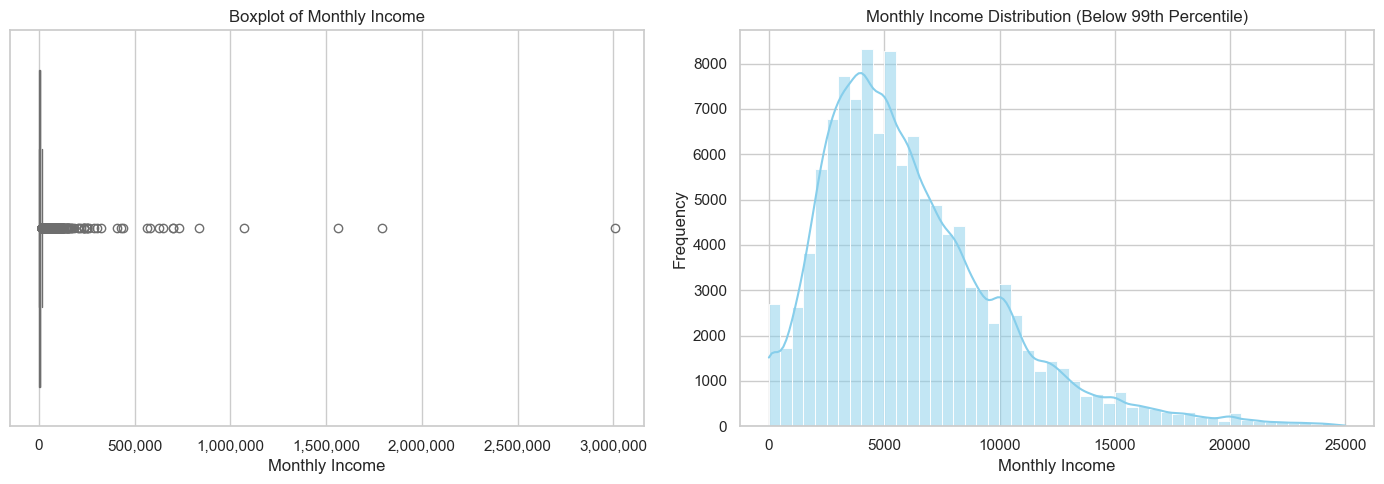

In [ ]:
# Filter out extreme values using the 99th percentile
upper_limit = df["MonthlyIncome"].quantile(0.99)
filtered_income = df[df["MonthlyIncome"] < upper_limit]["MonthlyIncome"]

# Set up figure with 2 subplots (boxplot first, then histogram)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot with full data
sns.boxplot(x=df["MonthlyIncome"], ax=axes[0], color="lightcoral")
axes[0].set_title("Boxplot of Monthly Income")
axes[0].set_xlabel("Monthly Income")
axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

# Histogram with KDE (filtered data)
sns.histplot(filtered_income, bins=50, kde=True, ax=axes[1], color="skyblue")
axes[1].set_title("Monthly Income Distribution (Below 99th Percentile)")
axes[1].set_xlabel("Monthly Income")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


To better understand the distribution of `MonthlyIncome`, two visualizations are provided:

- A **boxplot** displaying the full range of values, including extreme outliers.
- A **histogram with KDE** restricted to values below the 99th percentile, allowing a clearer view of the central distribution.

**📝 Interpretation:**

- The boxplot highlights the presence of extreme income values, with several outliers far beyond the typical range.
- The filtered histogram shows that the majority of individuals report monthly incomes between \$0 and \$20,000, with a noticeable right skew.
- Given the skewed distribution and presence of extreme outliers, **median imputation** is considered a more robust and appropriate strategy for handling missing values in the `MonthlyIncome` variable.


### 6.1.2 NumberOfDependents Distribution 👪

The `NumberOfDependents` variable is now examined to understand its typical range and distribution.


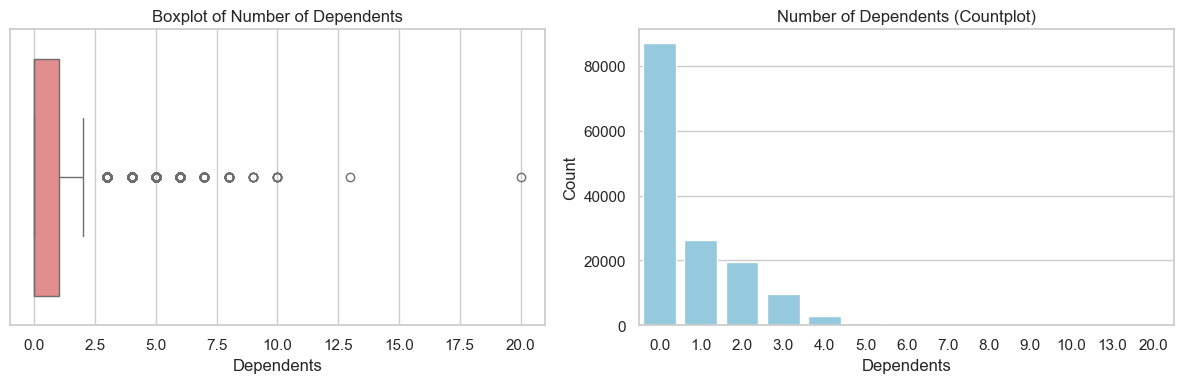

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Boxplot (full range)
sns.boxplot(x=df["NumberOfDependents"], ax=axes[0], color="lightcoral")
axes[0].set_title("Boxplot of Number of Dependents")
axes[0].set_xlabel("Dependents")

# Countplot (frequency of each value)
sns.countplot(x="NumberOfDependents", data=df, ax=axes[1], color="skyblue")
axes[1].set_title("Number of Dependents (Countplot)")
axes[1].set_xlabel("Dependents")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


To evaluate how to handle missing values in this feature, both a boxplot and a countplot are used to assess the frequency and potential outliers.

**📝 Interpretation:**

- The boxplot reveals the presence of a few high outliers, with reported values reaching up to 20 dependents.
- The countplot shows that the majority of individuals report between 0 and 2 dependents.
- Given the discrete and categorical-like nature of the variable, along with its strong concentration at lower values, **mode imputation** is considered an appropriate strategy for filling in missing entries.

### 6.1.3 Imputation Strategy Summary 🧩

This section outlines the approach used to handle missing values in the dataset through appropriate imputation techniques.

Two variables were identified with missing values:
- `MonthlyIncome` (~19.8%)
- `NumberOfDependents` (~2.6%)

To ensure robustness and explore potential improvements, multiple imputation strategies were considered:
- **Simple methods**: Median (for `MonthlyIncome`) and mode (for `NumberOfDependents`)
- **Advanced methods**: K-Nearest Neighbors (KNN) and Iterative Imputer (MICE-style)

The final decision on which method to apply was guided by both the distributional analysis of each variable and their observed correlation with other features in the dataset.


In [ ]:
# Save a copy before any cleaning steps
df_raw = df.copy()

# Method 1: Median Imputation
median_income = df_raw["MonthlyIncome"].median()
df_raw["Income_Median"] = df_raw["MonthlyIncome"].fillna(median_income)

mode_dependents = df_raw["NumberOfDependents"].mode()[0]
df_raw["Dependents_Mode"] = df_raw["NumberOfDependents"].fillna(mode_dependents)


In [14]:
# Method 2: KNN Imputation (fit on all columns, use only MonthlyIncome)
knn_imputer = KNNImputer(n_neighbors=5)
df_knn_result = pd.DataFrame(knn_imputer.fit_transform(df_raw), columns=df_raw.columns)
df_raw["Income_KNN"] = df_knn_result["MonthlyIncome"]
df_raw["Dependents_KNN"] = df_knn_result["NumberOfDependents"]

# Method 3: Iterative Imputer (MICE-style)
iter_imputer = IterativeImputer(random_state=0)
df_iter_result = pd.DataFrame(iter_imputer.fit_transform(df_raw), columns=df_raw.columns)
df_raw["Income_Iter"] = df_iter_result["MonthlyIncome"]
df_raw["Dependents_Iter"] = df_iter_result["NumberOfDependents"]

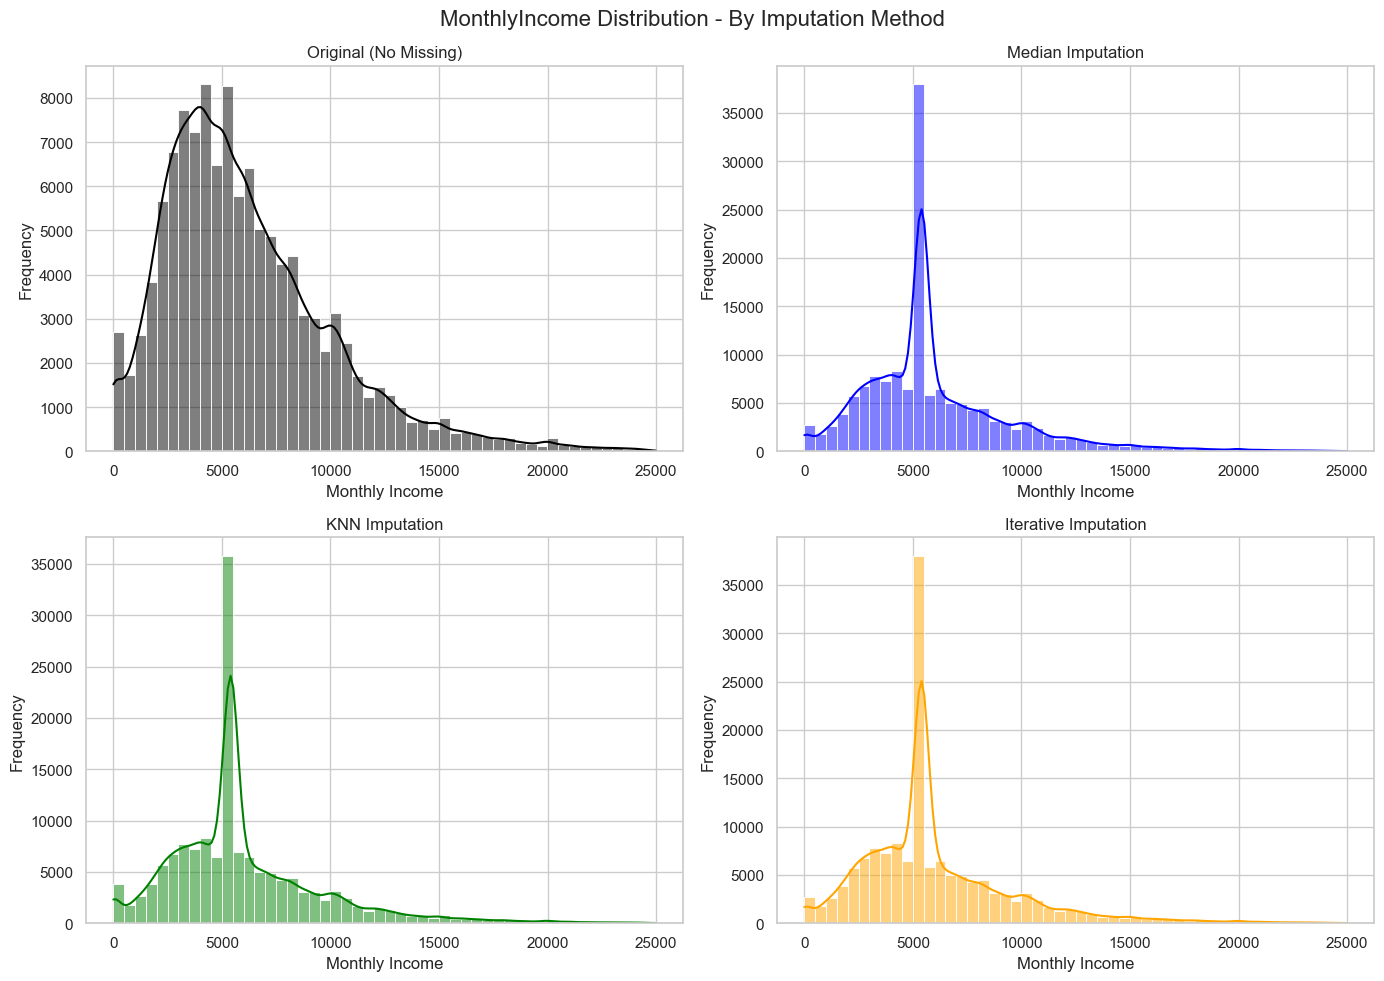

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
cap_income = df_raw["MonthlyIncome"].quantile(0.99)

# Original
sns.histplot(df_raw[df_raw["MonthlyIncome"] < cap_income]["MonthlyIncome"].dropna(),
             bins=50, kde=True, ax=axes[0, 0], color='black')
axes[0, 0].set_title("Original (No Missing)")

# Median
sns.histplot(df_raw[df_raw["Income_Median"] < cap_income]["Income_Median"],
             bins=50, kde=True, ax=axes[0, 1], color='blue')
axes[0, 1].set_title("Median Imputation")

# KNN
sns.histplot(df_raw[df_raw["Income_KNN"] < cap_income]["Income_KNN"],
             bins=50, kde=True, ax=axes[1, 0], color='green')
axes[1, 0].set_title("KNN Imputation")

# Iterative
sns.histplot(df_raw[df_raw["Income_Iter"] < cap_income]["Income_Iter"],
             bins=50, kde=True, ax=axes[1, 1], color='orange')
axes[1, 1].set_title("Iterative Imputation")

# Final layout
for ax in axes.flat:
    ax.set_xlabel("Monthly Income")
    ax.set_ylabel("Frequency")
plt.suptitle("MonthlyIncome Distribution - By Imputation Method", fontsize=16)
plt.tight_layout()
plt.show()


### 🔍 Comparison of Imputation Methods for MonthlyIncome

The figure below presents a side-by-side comparison of four distributions for the `MonthlyIncome` variable:

- **Original (No Missing):** Distribution of non-null values before any imputation.
- **Median Imputation:** Missing values replaced with the median of the non-null distribution.
- **KNN Imputation:** Missing values estimated based on the nearest neighbors using other available features.
- **Iterative Imputation:** A multivariate approach that models each variable with missing values as a function of other variables.

**📝 Interpretation:**

- All three imputation methods successfully preserve the overall right-skewed shape of the income distribution.
- However, both **KNN** and **Iterative** imputations introduce a strong peak around the median, similar to **Median Imputation**, but with slight smoothing.
- **Median Imputation**, while simpler, results in a more pronounced spike at a single value, which may not reflect the natural variation in the data.
- The similarity among all three approaches suggests that any of them would be viable; however, due to the simplicity and low computational cost, **median imputation** is selected as the final method for this project.


In [16]:
#evaluate corralation 
df_raw.corr()["MonthlyIncome"].sort_values(ascending=False)

MonthlyIncome           1.000000
Income_Median           1.000000
RealEstateLoans         0.124959
OpenCreditLines         0.091455
NumberOfDependents      0.062647
Dependents_Mode         0.062647
age                     0.037717
RevolvingUtilization    0.007124
Income_KNN              0.000206
Income_Iter             0.000150
Dependents_Iter        -0.004052
Dependents_KNN         -0.004064
Times30_59DaysLate     -0.010217
Times60_89DaysLate     -0.011116
Times90DaysLate        -0.012743
SeriousDlqin2yrs       -0.019746
DebtToIncomeRatio      -0.028712
Name: MonthlyIncome, dtype: float64

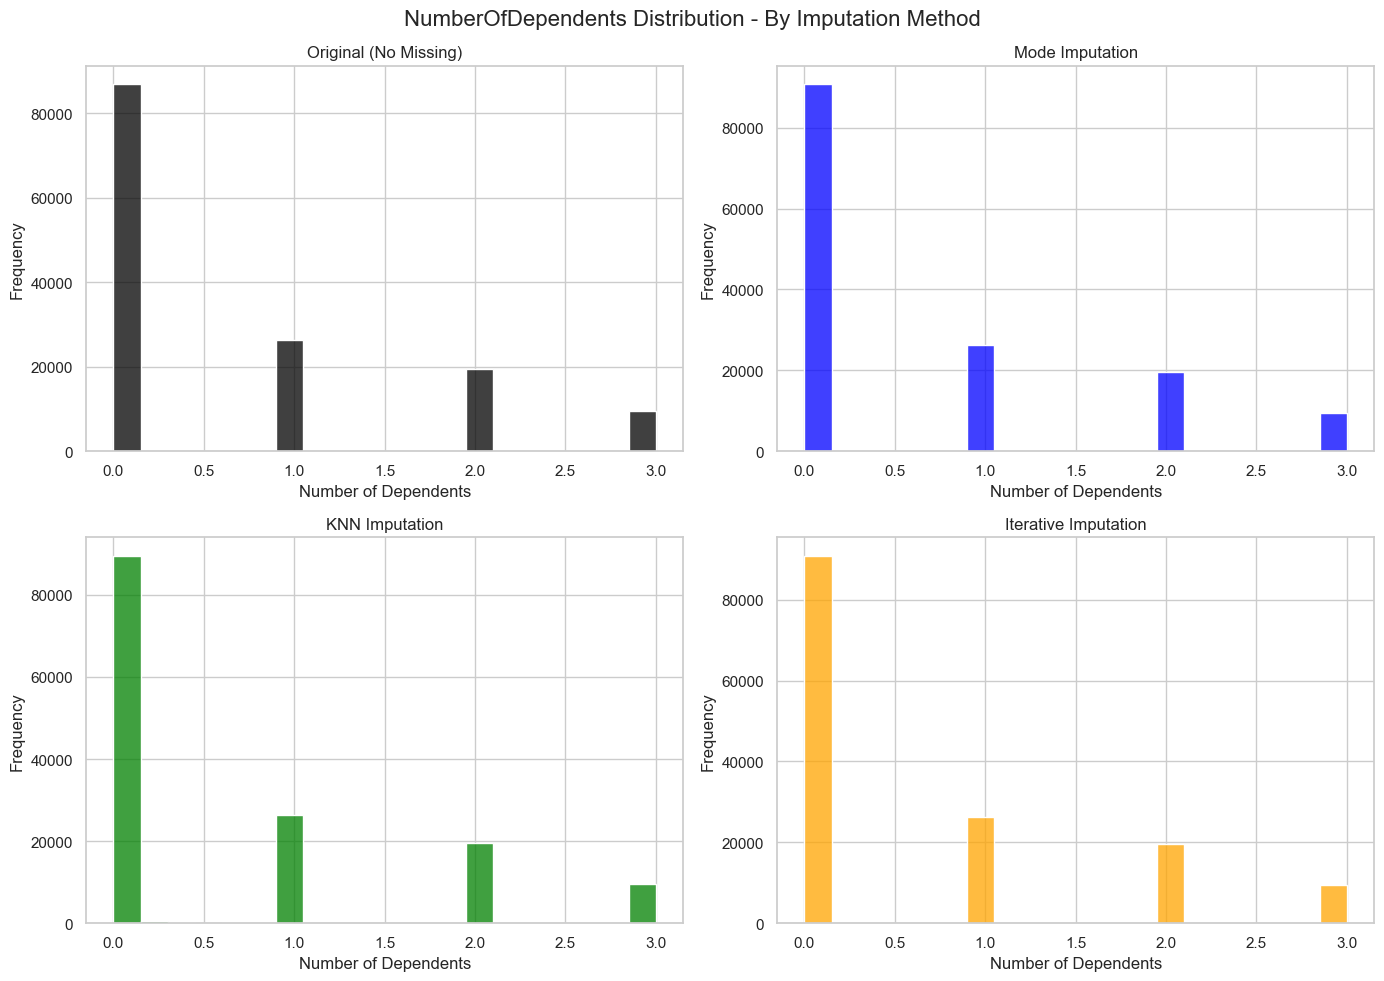

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Define cap for better visualization (99th percentile)
cap_dependents = df_raw["NumberOfDependents"].quantile(0.99)

# Original (no missing)
sns.histplot(df_raw[df_raw["NumberOfDependents"] < cap_dependents]["NumberOfDependents"].dropna(),
             bins=20, kde=False, ax=axes[0, 0], color='black')
axes[0, 0].set_title("Original (No Missing)")

# Mode Imputation
sns.histplot(df_raw[df_raw["Dependents_Mode"] < cap_dependents]["Dependents_Mode"],
             bins=20, kde=False, ax=axes[0, 1], color='blue')
axes[0, 1].set_title("Mode Imputation")

# KNN Imputation
sns.histplot(df_raw[df_raw["Dependents_KNN"] < cap_dependents]["Dependents_KNN"],
             bins=20, kde=False, ax=axes[1, 0], color='green')
axes[1, 0].set_title("KNN Imputation")

# Iterative Imputation
sns.histplot(df_raw[df_raw["Dependents_Iter"] < cap_dependents]["Dependents_Iter"],
             bins=20, kde=False, ax=axes[1, 1], color='orange')
axes[1, 1].set_title("Iterative Imputation")

# Final layout
for ax in axes.flat:
    ax.set_xlabel("Number of Dependents")
    ax.set_ylabel("Frequency")

plt.suptitle("NumberOfDependents Distribution - By Imputation Method", fontsize=16)
plt.tight_layout()
plt.show()


### 🔍 Comparison of Imputation Methods for NumberOfDependents

The following figure presents a comparison of four imputation strategies applied to the `NumberOfDependents` variable:

- **Original (No Missing):** Distribution of non-null values before any imputation.
- **Mode Imputation:** Missing values replaced with the most frequent value (0).
- **KNN Imputation:** Missing values estimated using the nearest neighbors based on other available features.
- **Iterative Imputation:** A multivariate approach modeling each missing value as a function of the others.

**📝 Interpretation:**

- The original distribution is heavily skewed towards 0, with most individuals reporting between 0 and 2 dependents.
- All three imputation strategies preserve the general shape of the original distribution, with no significant distortion.
- Since the variable is discrete, skewed, and contains relatively few missing values (~2.6%), **mode imputation** offers a simple and effective solution without introducing unnecessary model complexity.
- Advanced imputation methods (KNN and Iterative) yield similar distributions, further supporting the choice of mode as the final method.


In [18]:
df_raw.head()

,SeriousDlqin2yrs,RevolvingUtilization,age,Times30_59DaysLate,DebtToIncomeRatio,MonthlyIncome,OpenCreditLines,Times90DaysLate,RealEstateLoans,Times60_89DaysLate,NumberOfDependents,Income_Median,Dependents_Mode,Income_KNN,Dependents_KNN,Income_Iter,Dependents_Iter
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,9120.0,2.0,2600.0,1.0,2600.0,1.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,2600.0,1.0,3042.0,0.0,3042.0,0.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,3042.0,0.0,3300.0,0.0,3300.0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,3300.0,0.0,63588.0,0.0,63588.0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,63588.0,0.0,3500.0,1.0,3500.0,1.0


In [19]:
df_raw = df_raw.drop(columns=["MonthlyIncome","NumberOfDependents",
    "Income_KNN", "Income_Iter",
    "Dependents_KNN", "Dependents_Iter"
])

df_raw.rename(columns={
    "Income_Median": "MonthlyIncome",
    "Dependents_Mode": "NumberOfDependents"
}, inplace=True)

df_raw.head()

,SeriousDlqin2yrs,RevolvingUtilization,age,Times30_59DaysLate,DebtToIncomeRatio,OpenCreditLines,Times90DaysLate,RealEstateLoans,Times60_89DaysLate,MonthlyIncome,NumberOfDependents
1,1,0.766127,45,2,0.802982,13,0,6,0,9120.0,2.0
2,0,0.957151,40,0,0.121876,4,0,0,0,2600.0,1.0
3,0,0.658180,38,1,0.085113,2,1,0,0,3042.0,0.0
4,0,0.233810,30,0,0.036050,5,0,0,0,3300.0,0.0
5,0,0.907239,49,1,0.024926,7,0,1,0,63588.0,0.0


In [20]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   SeriousDlqin2yrs      150000 non-null  int64  
 1   RevolvingUtilization  150000 non-null  float64
 2   age                   150000 non-null  int64  
 3   Times30_59DaysLate    150000 non-null  int64  
 4   DebtToIncomeRatio     150000 non-null  float64
 5   OpenCreditLines       150000 non-null  int64  
 6   Times90DaysLate       150000 non-null  int64  
 7   RealEstateLoans       150000 non-null  int64  
 8   Times60_89DaysLate    150000 non-null  int64  
 9   MonthlyIncome         150000 non-null  float64
 10  NumberOfDependents    150000 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 13.7 MB


### ✅ Final Imputation Strategy

Based on the preceding distributional analysis and comparison of imputation methods:

- **Median imputation** was selected for `MonthlyIncome`
- **Mode imputation** was selected for `NumberOfDependents`

These strategies were chosen due to their simplicity, computational efficiency, and close alignment with the original data distributions.

The original variables and alternative imputed versions are now dropped, and the selected imputed columns are renamed accordingly to preserve consistency in the dataset.


## 6.2 Outlier Detection and Treatment 🚨

This section focuses on identifying and addressing outliers in the dataset to improve data quality and model performance.

The following steps are performed:
- Visual identification of outliers using boxplots
- Review of upper limits and detection of abnormal values in specific variables
- Definition of capping thresholds or correction rules based on percentiles and domain knowledge

The objective is to reduce the influence of extreme values while preserving the overall structure and integrity of the dataset.


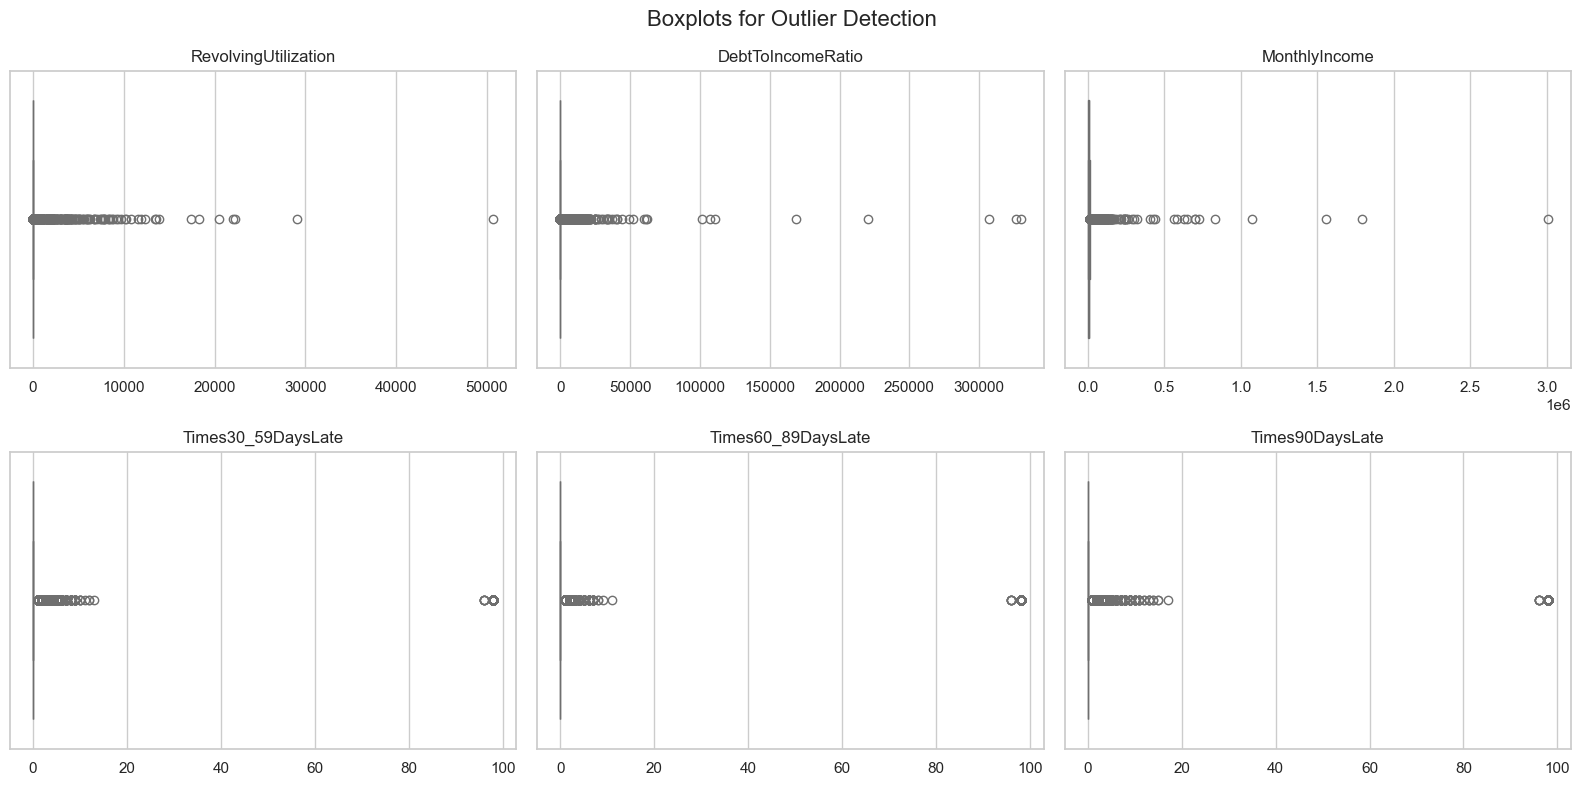

In [21]:
# Variables to analyze
outlier_vars = [
    "RevolvingUtilization",
    "DebtToIncomeRatio",
    "MonthlyIncome",
    "Times30_59DaysLate",
    "Times60_89DaysLate",
    "Times90DaysLate"
]

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
axes = axes.flatten()

# Plot boxplots
for i, var in enumerate(outlier_vars):
    sns.boxplot(x=df[var], ax=axes[i], color="skyblue")
    axes[i].set_title(var)
    axes[i].set_xlabel("")

plt.suptitle("Boxplots for Outlier Detection", fontsize=16)
plt.tight_layout()
plt.show()


The boxplots clearly reveal the presence of extreme outliers across several variables:

- `MonthlyIncome`, `DebtToIncomeRatio`, and `RevolvingUtilization` display unusually high values that fall far outside typical ranges.
- The delinquency-related variables (`Times30_59DaysLate`, `Times60_89DaysLate`, and `Times90DaysLate`) exhibit repeated extreme values such as **96** and **98**, which are likely placeholder codes or data entry errors.

These observations highlight the importance of applying targeted outlier treatment strategies in the subsequent steps.


## 6.2.1 Outlier Treatment 🧽

Extreme values were identified in several numeric variables. To mitigate their potential impact on model performance while preserving the overall structure of the data, the following treatment strategies were applied:

- **RevolvingUtilization**: Clipped at a maximum of 1.0 (100%), as values above this threshold are not realistic for a variable that represents credit usage as a proportion of available credit.
- **DebtToIncomeRatio**: Although the 99th percentile is approximately 4,979, this value is considered unrealistically high. Based on domain knowledge, values were capped at **1.0** (100%) to reflect a reasonable upper threshold for monthly debt obligations relative to income and to prevent the influence of extreme reporting errors.
- **MonthlyIncome**: After imputation, values were capped at the 99th percentile to reduce the impact of outliers and potential data entry errors.
- **Times30_59DaysLate**, **Times60_89DaysLate**, and **Times90DaysLate**: Records containing placeholder values (96 or 98) were removed from the dataset due to their inconsistency with normal reporting patterns.
- **Age**: Capped between 18 and 80 years to remove unrealistic entries.

These adjustments were designed to improve model stability and ensure data quality without distorting the original distributions of the variables.

Note: The variables `OpenCreditLines` and `RealEstateLoans` were reviewed but not capped, as their distributions, while skewed, are valid count variables. The observed extreme values were rare but not necessarily erroneous, and were retained to preserve potential informative value for modeling.


In [26]:
# Create a clean copy of the preprocessed dataset
df_clean = df_raw.copy()

# 1. Remove records with placeholder delinquency values (96 or 98)
past_due_cols = ["Times30_59DaysLate", "Times60_89DaysLate", "Times90DaysLate"]
for col in past_due_cols:
    df_clean = df_clean[~df_clean[col].isin([96, 98])]

# 2. Clip RevolvingUtilization at 1.0 (100%)
df_clean["RevolvingUtilization"] = df_clean["RevolvingUtilization"].clip(upper=1.0)

# 3. Clip DebtToIncomeRatio at 1.0 (100% of income)
df_clean["DebtToIncomeRatio"] = df_clean["DebtToIncomeRatio"].clip(upper=1.0)

# 4. Clip MonthlyIncome at 99th percentile
income_cap = df_clean["MonthlyIncome"].quantile(0.99)
df_clean["MonthlyIncome"] = df_clean["MonthlyIncome"].clip(upper=income_cap)

# 5. Clip age between 18 and 80
df_clean["age"] = df_clean["age"].clip(lower=18, upper=80)

# Show new shape
df_clean.shape


(149731, 11)

### 📊 Outlier Correction Results

The following plots compare the distribution of selected variables **before and after outlier treatment**. Each row shows the effect of the applied capping or cleaning strategy.

- The corrected variables no longer exhibit extreme outliers that were present in the original data.
- The core distribution of each variable has been preserved, ensuring consistency for modeling.
- These transformations help reduce the influence of erroneous or extreme values while maintaining interpretability.

After applying all cleaning and preprocessing steps—including imputation and outlier treatment—the dataset contains **149,731 rows**, down from the original 150,000. This minimal reduction is due to the removal of entries with invalid delinquency codes (`96`, `98`) and is not expected to impact the model’s generalizability.


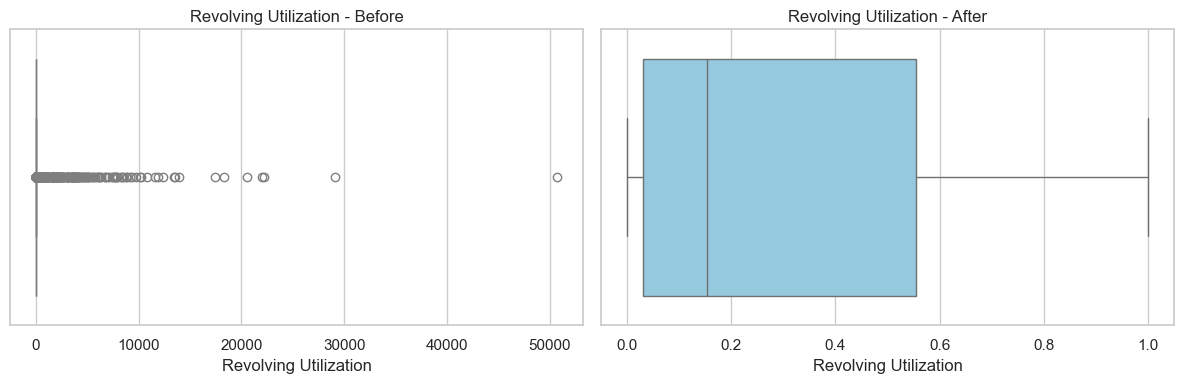

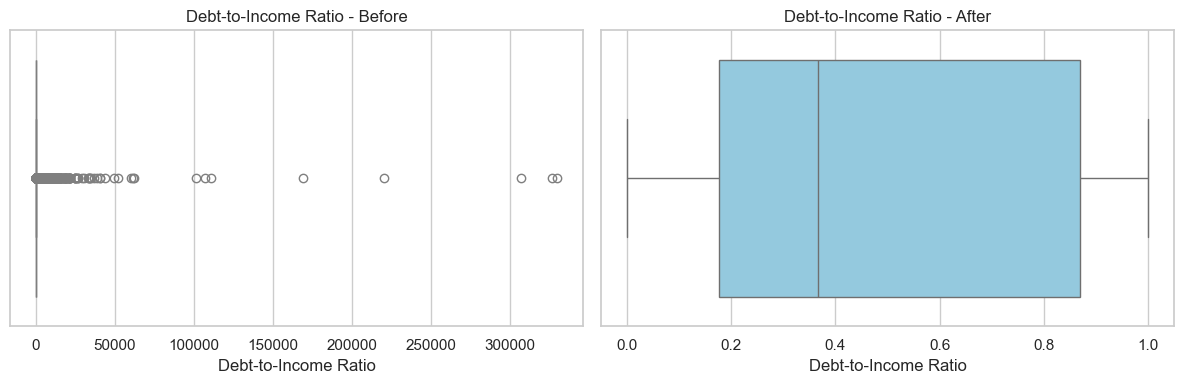

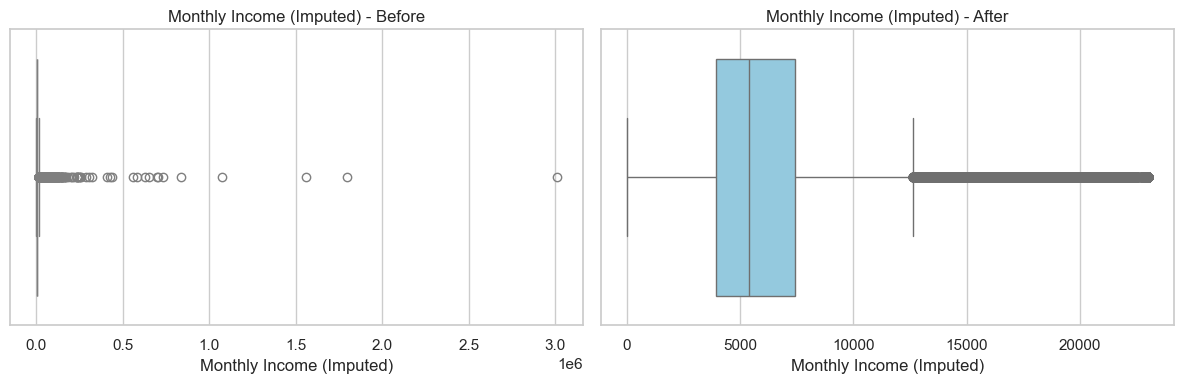

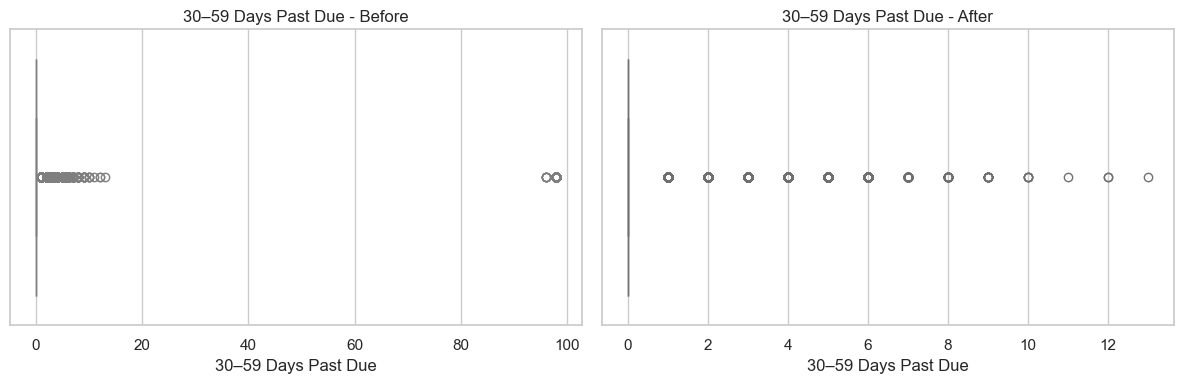

In [ ]:
# Lista de variables con etiquetas
vars_info = [
    ("RevolvingUtilization", "Revolving Utilization"),
    ("DebtToIncomeRatio", "Debt-to-Income Ratio"),
    ("MonthlyIncome", "Monthly Income (Imputed)"),
    ("Times30_59DaysLate", "30–59 Days Past Due")
]

# Generar una fila (2 gráficos) por variable
for col, label in vars_info:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Before
    sns.boxplot(x=df[col], ax=axes[0], color="lightgray")
    axes[0].set_title(f"{label} - Before")
    axes[0].set_xlabel(label)

    # After
    sns.boxplot(x=df_clean[col], ax=axes[1], color="skyblue")
    axes[1].set_title(f"{label} - After")
    axes[1].set_xlabel(label)

    plt.tight_layout()
    plt.show()


## 6.3  Duplicate Records Check  📑

As part of the final data cleaning step, duplicate records were examined and removed if present.

- The original dataset contained **150,000** entries.
- After imputation, outlier treatment, and removal of records with invalid delinquency values, the dataset contained **149,731** entries.
- An additional **2,121 duplicate rows** were identified and removed, resulting in a final cleaned dataset of **147,610 rows**.

Removing duplicates ensures that no data point is overrepresented, which could otherwise introduce bias into the model training process.


In [33]:
# Check for duplicates
duplicates = df_clean.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 2121


In [35]:
df_clean = df_clean.drop_duplicates()
duplicates = df_clean.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


In [36]:
print(f"Original dataset shape: {df.shape}")
print(f"Cleaned dataset shape:  {df_clean.shape}")


Original dataset shape: (150000, 11)
Cleaned dataset shape:  (147610, 11)


In [39]:
df_clean

,SeriousDlqin2yrs,RevolvingUtilization,age,Times30_59DaysLate,DebtToIncomeRatio,OpenCreditLines,Times90DaysLate,RealEstateLoans,Times60_89DaysLate,MonthlyIncome,NumberOfDependents
1,1,0.766127,45,2,0.802982,13,0,6,0,9120.0,2.0
2,0,0.957151,40,0,0.121876,4,0,0,0,2600.0,1.0
3,0,0.658180,38,1,0.085113,2,1,0,0,3042.0,0.0
4,0,0.233810,30,0,0.036050,5,0,0,0,3300.0,0.0
5,0,0.907239,49,1,0.024926,7,0,1,0,23011.9,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149996,0,0.040674,74,0,0.225131,4,0,1,0,2100.0,0.0
149997,0,0.299745,44,0,0.716562,4,0,1,0,5584.0,2.0
149998,0,0.246044,58,0,1.000000,18,0,1,0,5400.0,0.0
149999,0,0.000000,30,0,0.000000,4,0,0,0,5716.0,0.0


# 7. 📊 Exploratory Data Analysis (EDA)

With the dataset fully cleaned and preprocessed, this section explores key patterns, relationships, and distributions across variables.

The main objectives of this analysis are to:
- Examine the overall distribution of the target variable (`SeriousDlqin2yrs`)
- Analyze the shape, spread, and characteristics of input features
- Identify potential relationships between features and the target
- Generate evidence-driven insights to support future feature selection and modeling decisions


## 7.1  Target Variable Distribution 🎯

The target variable, `SeriousDlqin2yrs`, indicates whether a customer experienced serious delinquency (90+ days past due) within two years.

As shown in the plot below:
- **93.3%** of the records correspond to customers who **did not default** (class 0).
- Only **6.7%** of the records correspond to customers who **defaulted** (class 1).

**📝 Interpretation:**

This distribution reveals a significant class imbalance, with defaults representing a small minority of the dataset. This imbalance should be considered during model training, as it may bias the model toward predicting the majority class. Strategies such as **resampling**, **class weighting**, or **custom evaluation metrics (e.g., F1-score)** may be required to improve model performance on the minority class.


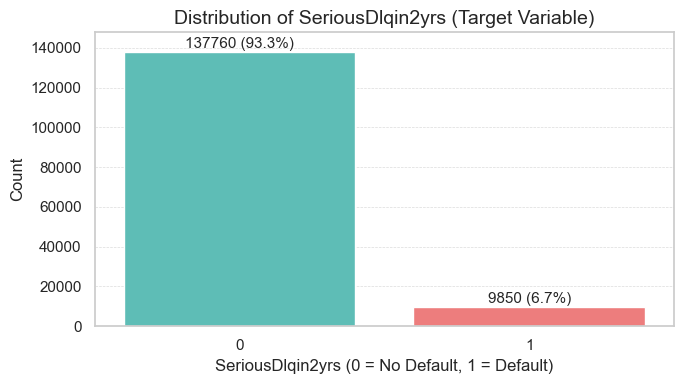

In [ ]:
# Create a copy to plot from the cleaned dataset
y_plot = df_clean[['SeriousDlqin2yrs']].copy()

# Map the proportion of each class (for annotation)
y_plot['proportion'] = y_plot['SeriousDlqin2yrs'].map(
    y_plot['SeriousDlqin2yrs'].value_counts(normalize=True)
)

# Count of each class (0 = No Default, 1 = Default)
counts = y_plot['SeriousDlqin2yrs'].value_counts()

# Set figure size
plt.figure(figsize=(7, 4))

# Plot the countplot with two colors (for 0 and 1)
ax = sns.countplot(
    data=y_plot,
    x='SeriousDlqin2yrs',
    hue='SeriousDlqin2yrs',
    palette=['#4ECDC4', '#FF6B6B'],
    legend=False
)

# Title and axis labels
plt.title('Distribution of SeriousDlqin2yrs (Target Variable)', fontsize=14)
plt.xlabel('SeriousDlqin2yrs (0 = No Default, 1 = Default)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

# Annotate bars with count and percentage
total = len(y_plot)
for p in ax.patches:
    height = p.get_height()
    label = f'{int(height)} ({height / total * 100:.1f}%)'
    ax.annotate(
        label,
        (p.get_x() + p.get_width() / 2., height + 500),
        ha='center', va='bottom', fontsize=11
    )

# Set upper margin for cleaner display
plt.ylim(0, counts.max() + 10000)
plt.tight_layout()
plt.show()


## 7.2  Univariate Analysis 📈

This section explores the individual distribution of numerical features to better understand their shape, central tendency, and variability.

The analysis includes:
- Continuous variables (e.g., income, utilization)
- Discrete count variables (e.g., number of credit lines or dependents)

Insights from this section will support feature transformation decisions (e.g., normalization or binning) and help detect potential data issues such as skewness or unusual distributions.


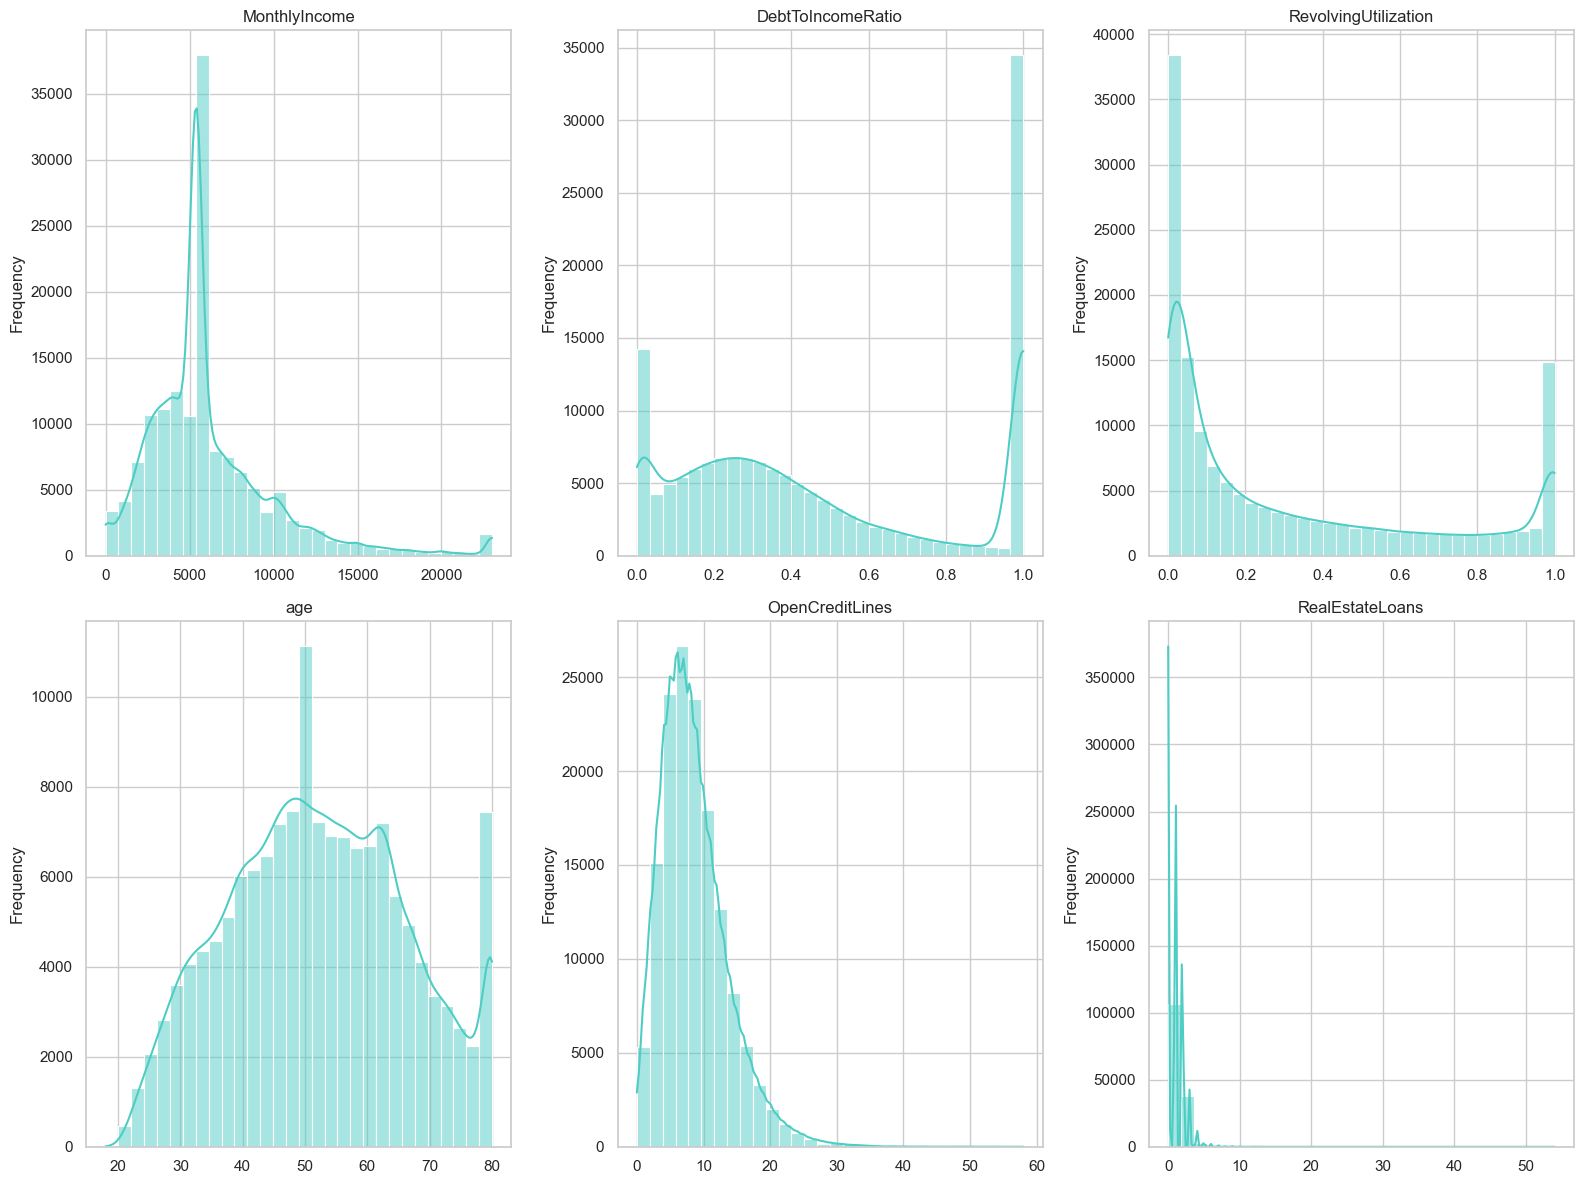

In [ ]:
# List of numerical features to analyze
num_features = [
    "MonthlyIncome",
    "DebtToIncomeRatio",
    "RevolvingUtilization",
    "age",
    "OpenCreditLines",
    "RealEstateLoans"
]

# Set number of columns for the subplot grid
n_cols = 3
# Calculate number of rows needed
n_rows = (len(num_features) + n_cols - 1) // n_cols

# Create subplot grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 12))
axes = axes.flatten()  # Flatten in case of 2D axes

# Plot each variable
for i, col in enumerate(num_features):
    sns.histplot(df_clean[col], kde=True, ax=axes[i], color="#4ECDC4", bins=30)
    axes[i].set_title(f"{col}", fontsize=12)
    axes[i].set_xlabel("")  # Optional: remove x-axis label to reduce clutter
    axes[i].set_ylabel("Frequency")

# Remove any empty subplots if the number of features doesn't fill all slots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust spacing to prevent overlapping elements
plt.tight_layout()
plt.show()


**📝 Observations:**

- `MonthlyIncome` shows a clear right skew, with a large concentration between \$5,000 and \$7,000. This supports the earlier decision to apply median imputation and capping at the 99th percentile to reduce the influence of outliers.
- `DebtToIncomeRatio` and `RevolvingUtilization` are both heavily skewed toward higher values, with a significant number of individuals near the upper cap of 1.0. This pattern reflects high leverage or utilization levels among certain individuals.
- `age` appears roughly symmetric but with visible spikes around ages **50** and **80**, which may indicate reporting artifacts or common thresholds in the dataset (e.g., retirement).
- `OpenCreditLines` and `RealEstateLoans` display expected count-based right-tailed distributions. Most individuals have fewer than **15 open credit lines** and fewer than **5 real estate loans**, with a long tail extending to higher values.

These distributions reinforce earlier cleaning decisions and will guide future feature transformation steps, such as normalization or binning, to improve model performance and stability.


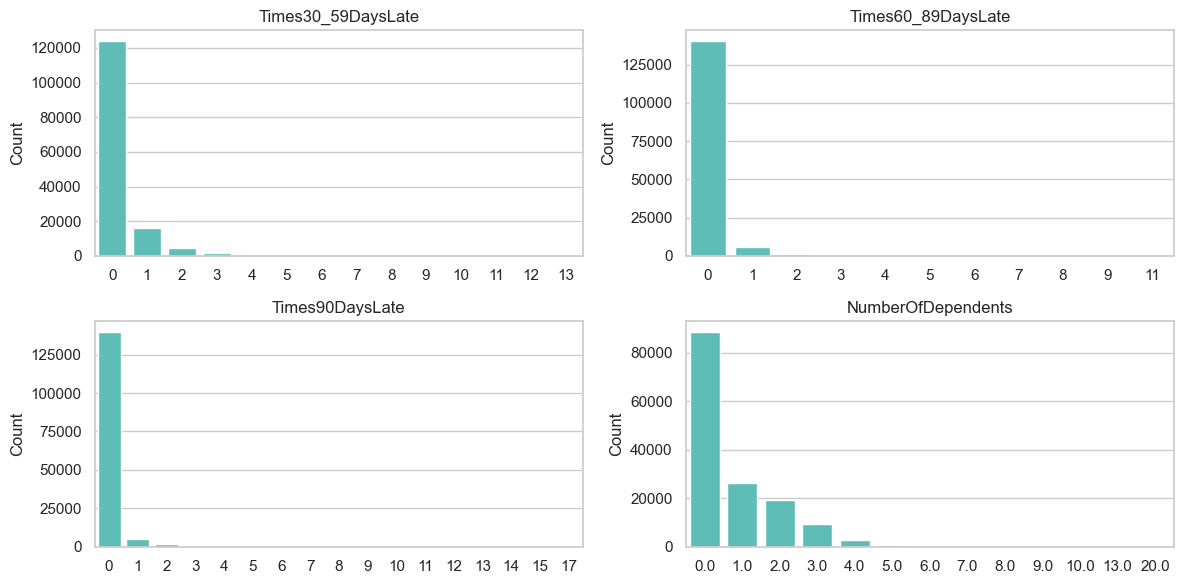

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of discrete variables to plot
discrete_features = [
    "Times30_59DaysLate",
    "Times60_89DaysLate",
    "Times90DaysLate",
    "NumberOfDependents"
]

# Set up subplot grid
n_cols = 2
n_rows = (len(discrete_features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6))
axes = axes.flatten()

# Plot each variable
for i, col in enumerate(discrete_features):
    sns.countplot(data=df_clean, x=col, ax=axes[i], color="#4ECDC4")
    axes[i].set_title(f"{col}", fontsize=12)
    axes[i].set_ylabel("Count")
    axes[i].set_xlabel("")

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


**📝 Observations:**

- All delinquency-related features are heavily skewed toward **zero**, which indicates that most individuals have not experienced late payments.
- The number of occurrences declines rapidly as the count increases, confirming that serious delinquency is rare.
- `NumberOfDependents` is concentrated at **0** and **1**, with very few individuals reporting more than 5 dependents.

These distributions reinforce the earlier findings during data cleaning and will help guide decisions in feature engineering, such as grouping infrequent values or applying binning to reduce sparsity.


## 7.4  Correlation Matrix 🔗

Before analyzing individual relationships between features and the target variable, a correlation matrix is used to explore the linear associations between numerical features.

This visualization helps:
- Detect strong linear relationships between features
- Identify potential multicollinearity issues
- Highlight variables that may carry overlapping information

Note: Since the target variable `SeriousDlqin2yrs` is binary, it is excluded from this correlation matrix and will be analyzed separately in the following section.


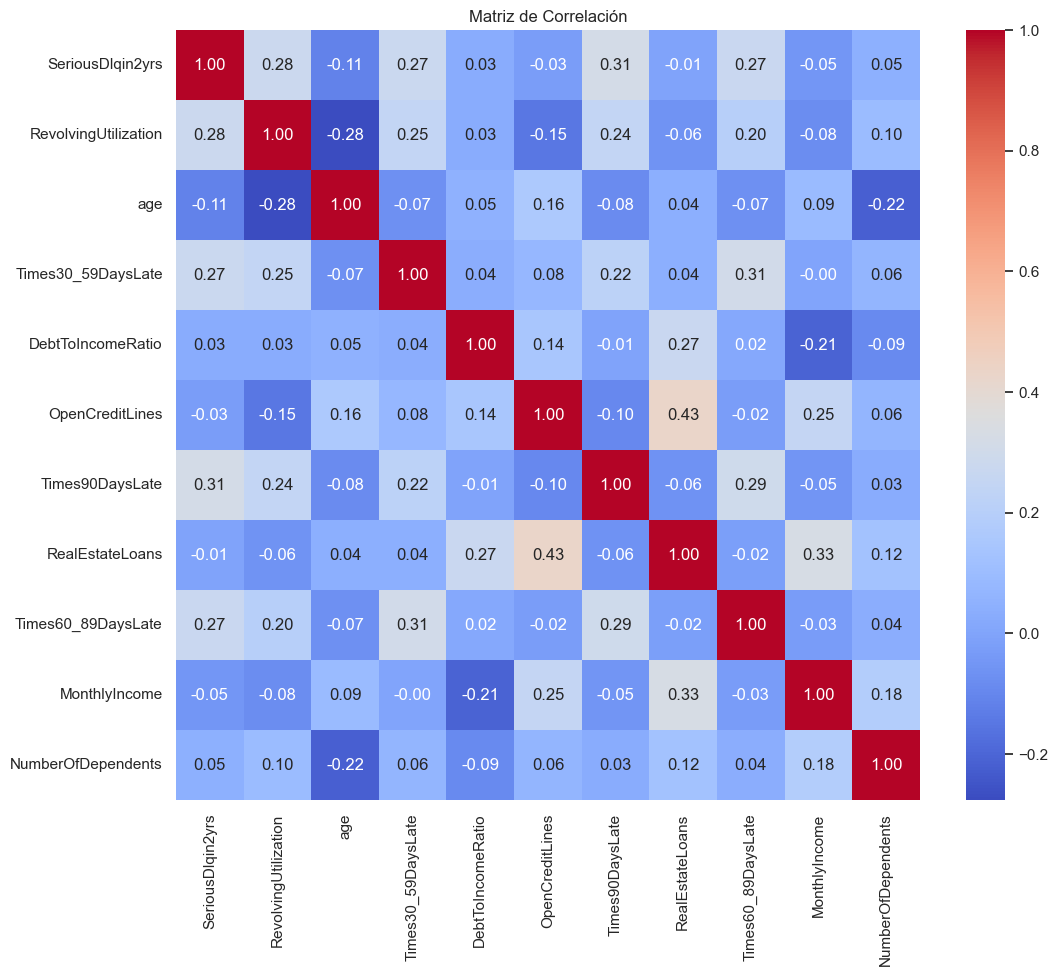

In [ ]:
# Calcular la matriz de correlación
correlation_matrix = df_clean.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de Correlación")
plt.show()


**📝 Observations:**

- The target variable `SeriousDlqin2yrs` shows the strongest positive correlations with:
  - `Times90DaysLate` (**0.31**)
  - `Times30_59DaysLate` (**0.27**)
  - `Times60_89DaysLate` (**0.27**)
  - `RevolvingUtilization` (**0.28**)

- Negative correlation is observed with:
  - `age` (**-0.11**), suggesting that younger individuals may have slightly higher risk of default.

- Moderate inter-correlations are present between the delinquency-related features, as expected, since they reflect similar behaviors over different time windows.

- No evidence of strong multicollinearity is observed among the predictors, but some weak-to-moderate correlations (e.g., between `OpenCreditLines` and `RealEstateLoans`) may still be considered for regularization or feature selection.

This correlation analysis provides a useful overview of the linear relationships between features and supports the selection of relevant predictors for the modeling phase.


## 7.5 Bivariate Analysis with Target Variable 📊

This section explores how each input feature relates to the target variable `SeriousDlqin2yrs`, which indicates whether a customer experienced serious delinquency.

The goal is to identify potential predictive relationships and assess how feature values vary across the default and non-default classes.

The analysis includes:
- **Boxplots** for continuous variables to assess differences in distribution
- **Barplots** for discrete variables to observe default rates or frequency patterns
- **Group-based summaries** to quantify default risk across feature levels

These insights will support feature selection, transformation, and model design in the next phase.

7.5.1 Boxplots 📦


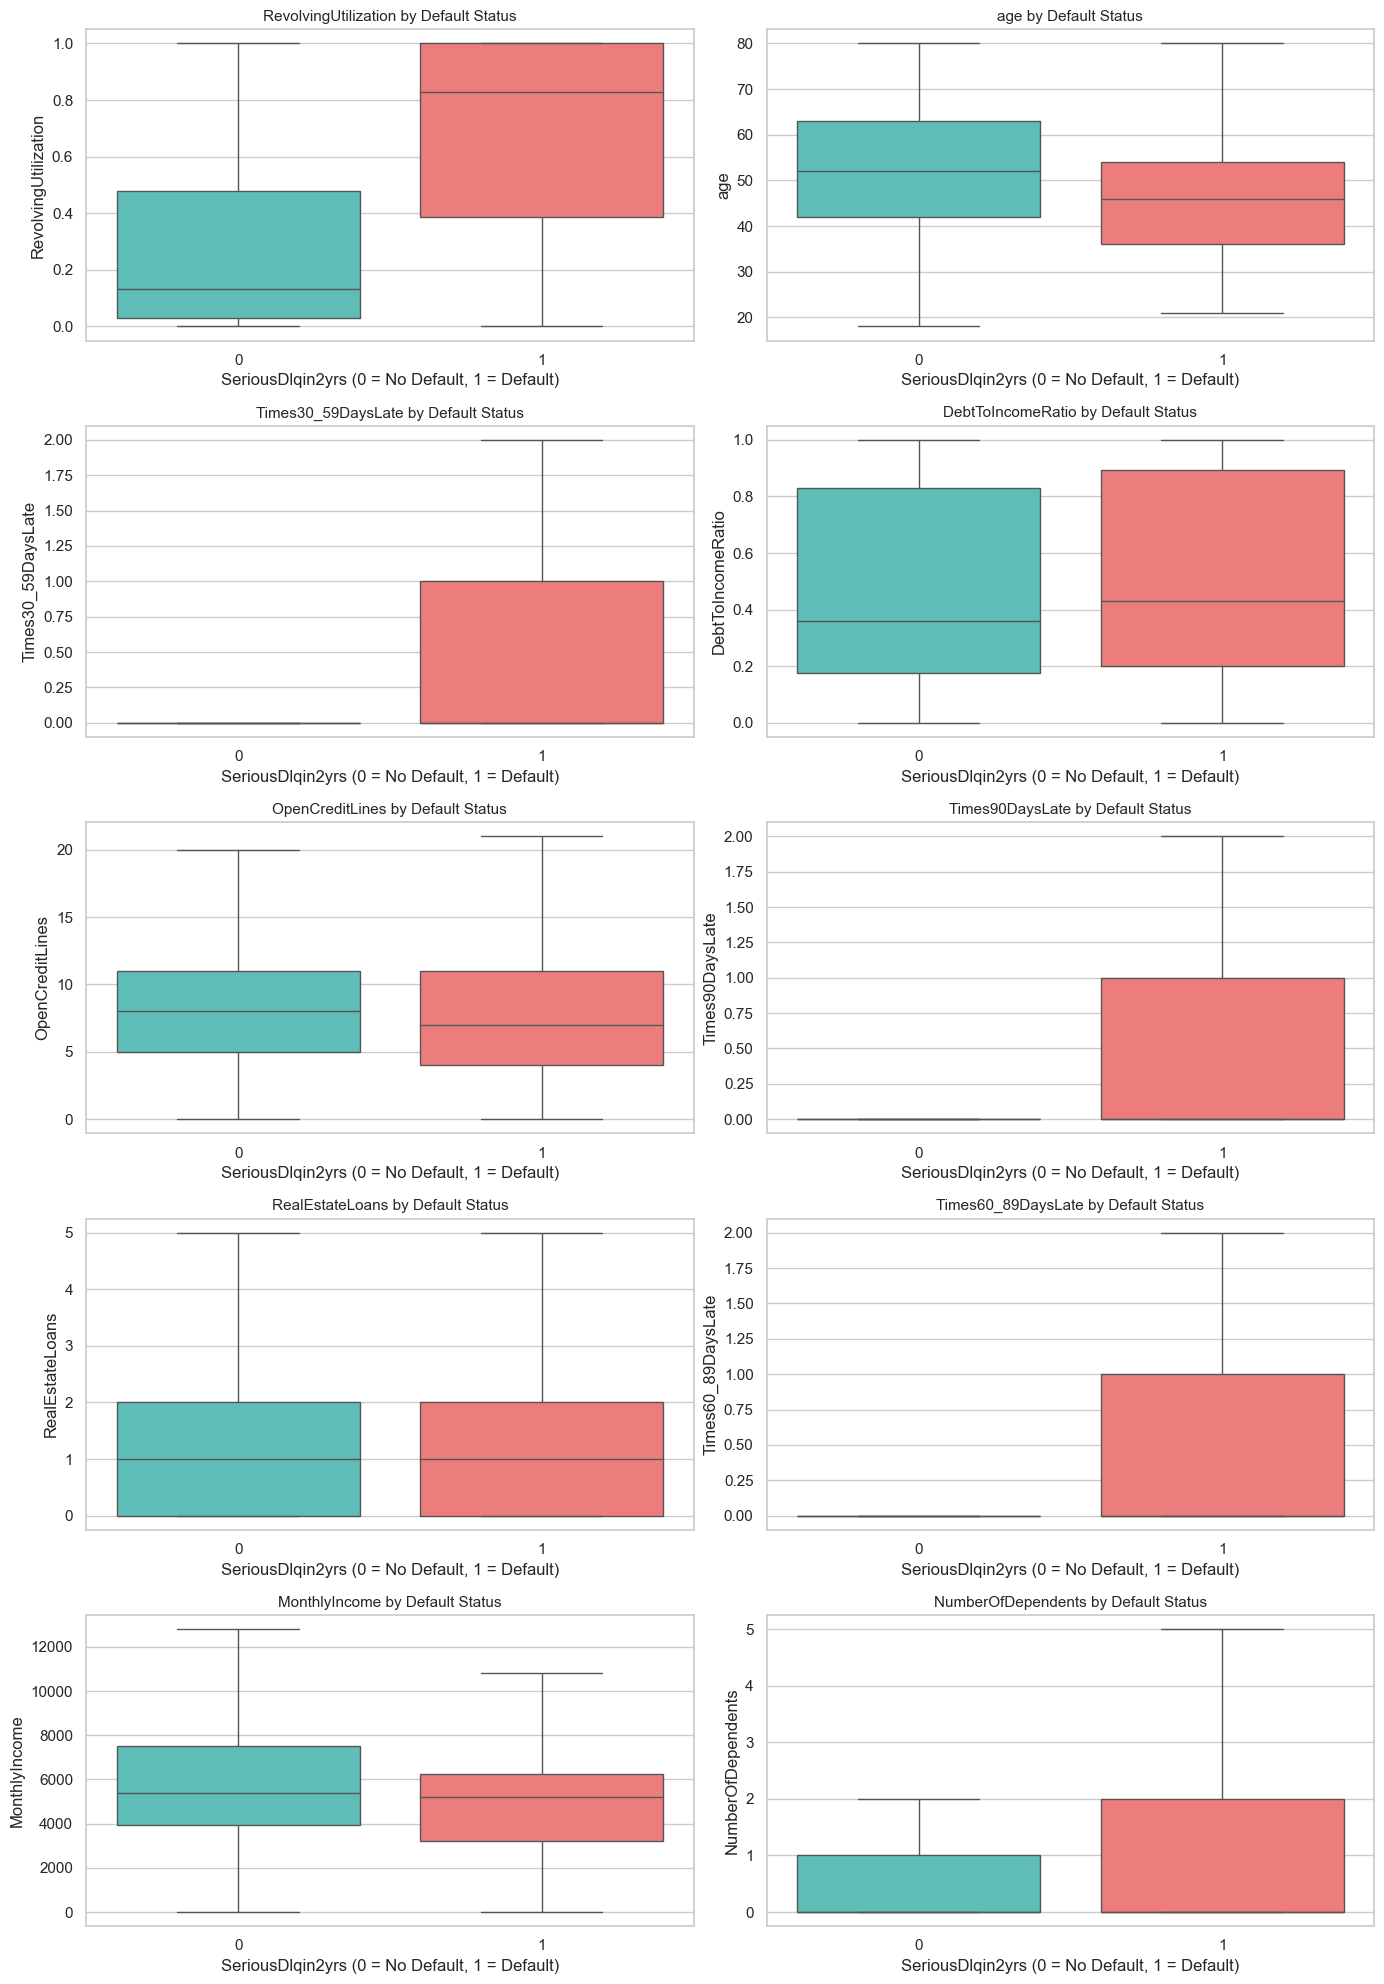

In [ ]:
# Select numeric features except the target
num_vars = df_clean.select_dtypes(include=['float64', 'int64']).columns.drop("SeriousDlqin2yrs")

# Custom color palette for classes
custom_palette = {1: "#FF6B6B", 0: "#4ECDC4"}

# Grid layout
cols_per_row = 2
n = len(num_vars)
rows = (n + cols_per_row - 1) // cols_per_row

fig, axes = plt.subplots(rows, cols_per_row, figsize=(14, 4 * rows))
axes = axes.flatten()

for i, var in enumerate(num_vars):
    sns.boxplot(
        x="SeriousDlqin2yrs", 
        y=var, 
        data=df_clean, 
        hue="SeriousDlqin2yrs", 
        palette=custom_palette, 
        ax=axes[i],
        showfliers=False,
        dodge=False,
        legend=False
    )
    axes[i].set_title(f"{var} by Default Status", fontsize=11)
    axes[i].set_xlabel("SeriousDlqin2yrs (0 = No Default, 1 = Default)")
    axes[i].set_ylabel(var)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


**📝 Observations:**

- Defaulted customers tend to have:
  - **Lower median income**
  - **Higher average revolving utilization**
  - **Fewer open credit lines**
  - **More late payment occurrences**

- These differences support the patterns observed in the boxplots and barplots, reinforcing the predictive value of these variables.

This quantitative summary provides a strong foundation for selecting relevant features for the modeling phase.

In [52]:
# Group by the target variable and calculate mean and median for each numeric feature
summary_stats = df_clean.groupby("SeriousDlqin2yrs").agg(["mean", "median"])

# Select only numeric columns (excluding the target)
numeric_cols = df_clean.select_dtypes(include=["float64", "int64"]).columns.drop("SeriousDlqin2yrs")

# Extract only those numeric columns from the MultiIndex DataFrame
summary_stats = summary_stats[numeric_cols]

# Round values for cleaner display
summary_stats = summary_stats.round(2)

# Display the table
display(summary_stats)


RevolvingUtilization           age        Times30_59DaysLate  \
                                 mean median   mean median               mean   
SeriousDlqin2yrs                                                                
0                                0.29   0.13  52.54   52.0               0.20   
1                                0.68   0.83  46.03   46.0               0.97   

                        DebtToIncomeRatio        OpenCreditLines         \
                 median              mean median            mean median   
SeriousDlqin2yrs                                                          
0                   0.0              0.46   0.36            8.58    8.0   
1                   0.0              0.50   0.43            8.02    7.0   

                 Times90DaysLate        RealEstateLoans         \
                            mean median            mean median   
SeriousDlqin2yrs                                                 
0                           0.05    0.0            1.03    1.0   
1                           0.67    0.0            1.01    1.0   

                 Times60_89DaysLate        MonthlyIncome          \
                               mean median          mean  median   
SeriousDlqin2yrs                                                   
0                              0.04    0.0       6211.34  5400.0   
1                              0.40    0.0       5455.99  5226.0   

                 NumberOfDependents         
                               mean median  
SeriousDlqin2yrs                            
0                              0.73    0.0  
1                              0.94    0.0

### 7.5.2 Barplots – Default Rate by Feature 📊

The following barplots display the default rate (`SeriousDlqin2yrs`) across different feature values or binned ranges.

### Key Insights:

- **Delinquency-related variables** (`Times30_59DaysLate`, `Times60_89DaysLate`, `Times90DaysLate`) show a **strong positive relationship** with the default rate. Just a single late payment significantly increases the probability of default.
- **`NumberOfDependents`** presents a mild increase in default rate up to 6 dependents, but no clear trend beyond that. Most extreme values (e.g., 10+) show 0% default likely due to very small sample sizes.
- **`MonthlyIncome`** reveals a **negative correlation** with default: lower income brackets (under \$6,000/month) have higher default rates, while higher incomes show relatively stable low risk.
- **`age`** shows a clear inverse relationship with default: **younger customers have a significantly higher default rate** compared to older age groups.
- **`DebtToIncomeRatio`** and **`RevolvingUtilization`** also demonstrate rising default rates with higher financial pressure (i.e., higher utilization or debt levels). Notably, customers with utilization close to 1.0 have a much higher likelihood of default.

These visualizations confirm the **predictive importance** of financial behavior and demographic variables and will be instrumental in guiding feature selection and transformation in the modeling phase.


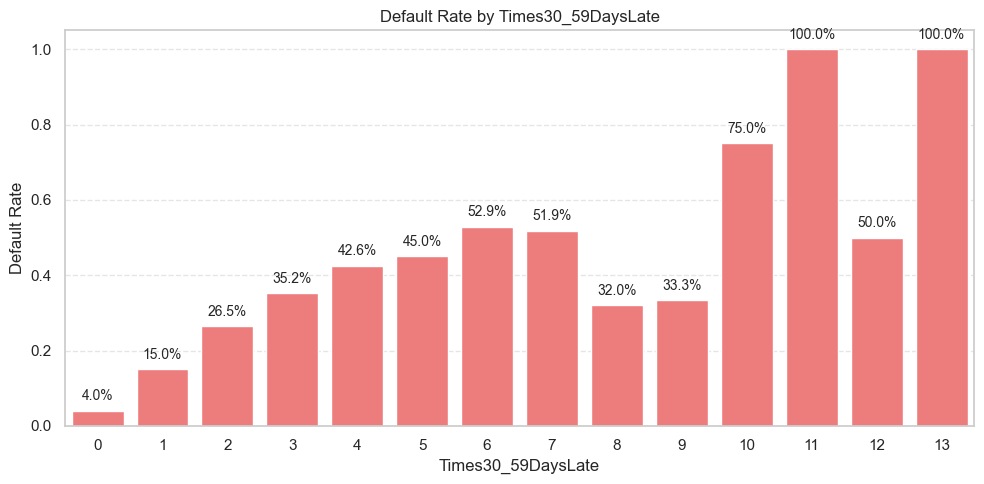

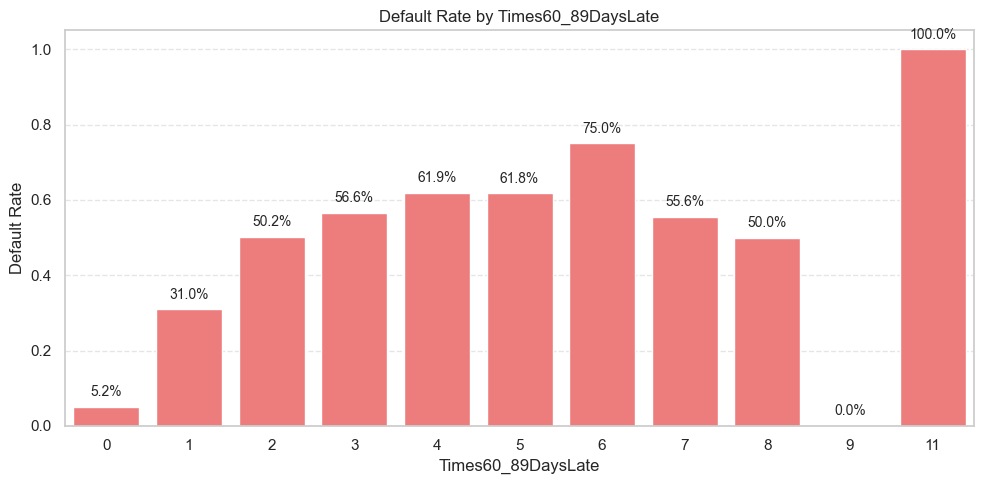

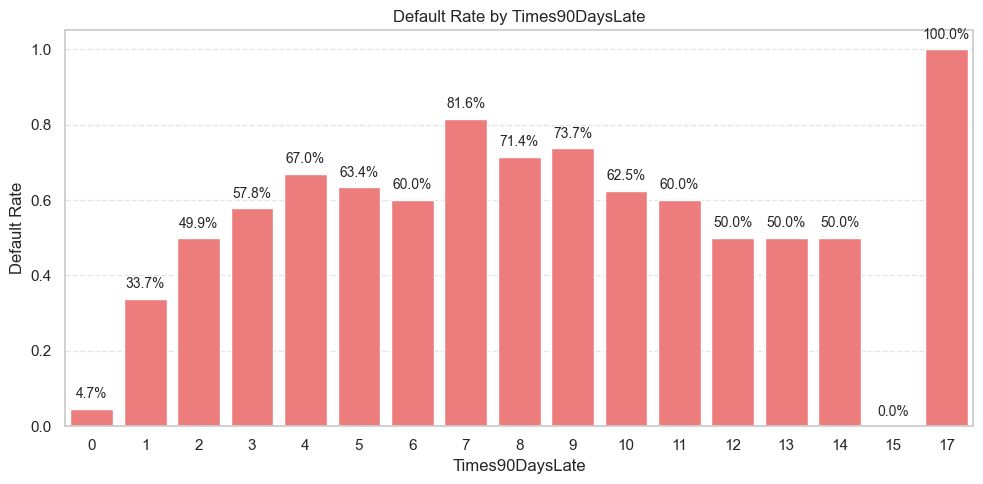

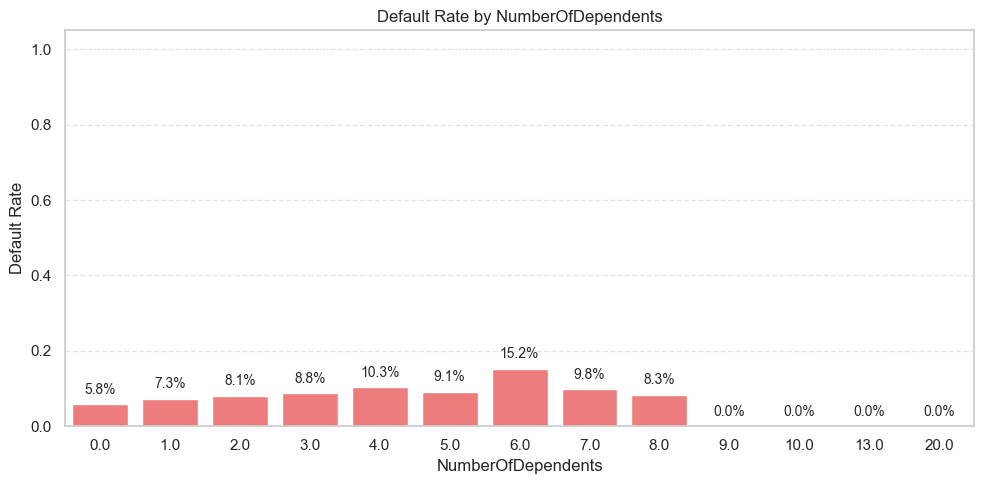

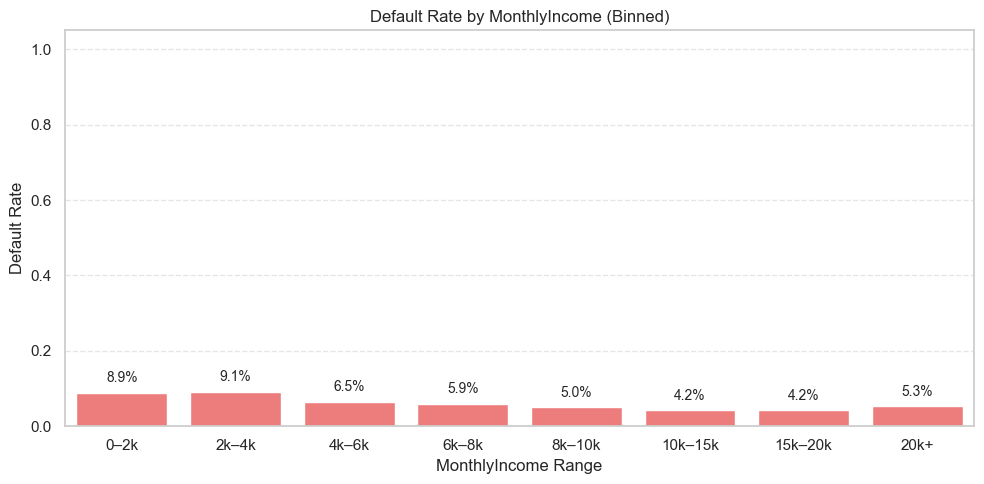

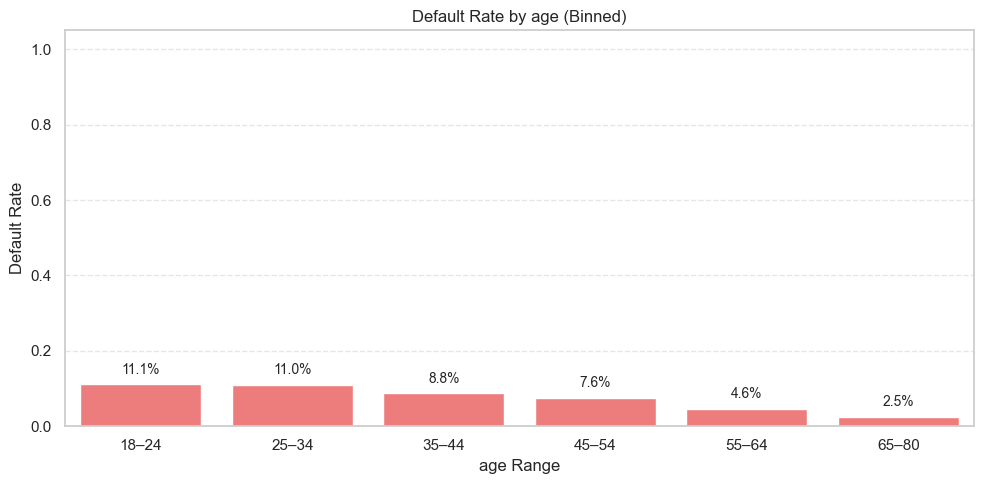

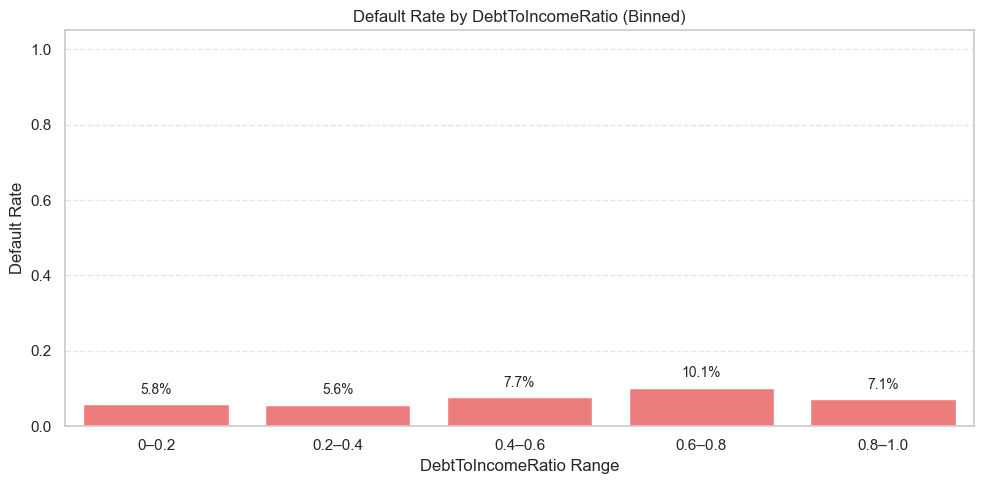

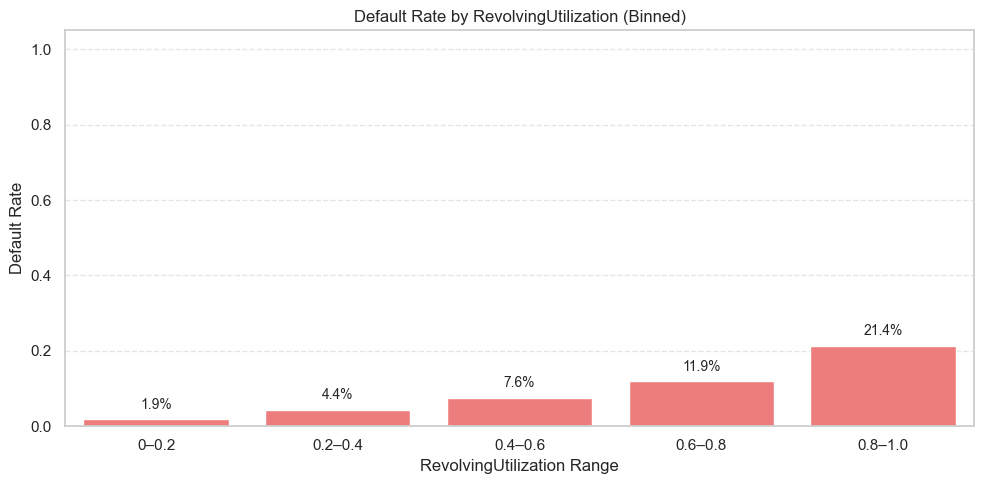

In [ ]:
# Barplot for discrete variables (with percentage labels)
def plot_default_rate_by_discrete(feature):
    grouped = df_clean.groupby(feature)['SeriousDlqin2yrs'].mean().reset_index()

    plt.figure(figsize=(10, 5))
    ax = sns.barplot(data=grouped, x=feature, y='SeriousDlqin2yrs', color="#FF6B6B")

    # Annotate each bar with percentage
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.1%}', (p.get_x() + p.get_width() / 2., height + 0.02),
                    ha='center', va='bottom', fontsize=10)

    plt.title(f"Default Rate by {feature}")
    plt.xlabel(feature)
    plt.ylabel("Default Rate")
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Barplot for continuous variables (with binning, percentage labels, and warning fix)
def plot_default_rate_by_binned(feature, bins, labels):
    df_temp = df_clean.copy()
    df_temp[f'{feature}_bin'] = pd.cut(df_temp[feature], bins=bins, labels=labels)

    grouped = df_temp.groupby(f'{feature}_bin', observed=False)['SeriousDlqin2yrs'].mean().reset_index()

    plt.figure(figsize=(10, 5))
    ax = sns.barplot(data=grouped, x=f'{feature}_bin', y='SeriousDlqin2yrs', color="#FF6B6B")

    # Annotate each bar with percentage
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.1%}', (p.get_x() + p.get_width() / 2., height + 0.02),
                    ha='center', va='bottom', fontsize=10)

    plt.title(f"Default Rate by {feature} (Binned)")
    plt.xlabel(f"{feature} Range")
    plt.ylabel("Default Rate")
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()



# ---- Run visualizations ----

# Discrete features
plot_default_rate_by_discrete("Times30_59DaysLate")
plot_default_rate_by_discrete("Times60_89DaysLate")
plot_default_rate_by_discrete("Times90DaysLate")
plot_default_rate_by_discrete("NumberOfDependents")

# Continuous features (with binning)
plot_default_rate_by_binned(
    feature="MonthlyIncome",
    bins=[0, 2000, 4000, 6000, 8000, 10000, 15000, 20000, df_clean["MonthlyIncome"].max()],
    labels=["0–2k", "2k–4k", "4k–6k", "6k–8k", "8k–10k", "10k–15k", "15k–20k", "20k+"]
)

plot_default_rate_by_binned(
    feature="age",
    bins=[18, 25, 35, 45, 55, 65, 80],
    labels=["18–24", "25–34", "35–44", "45–54", "55–64", "65–80"]
)

plot_default_rate_by_binned(
    feature="DebtToIncomeRatio",
    bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
    labels=["0–0.2", "0.2–0.4", "0.4–0.6", "0.6–0.8", "0.8–1.0"]
)

plot_default_rate_by_binned(
    feature="RevolvingUtilization",
    bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
    labels=["0–0.2", "0.2–0.4", "0.4–0.6", "0.6–0.8", "0.8–1.0"]
)


The exploratory data analysis provided valuable insights into the distribution and behavior of key features in relation to the target variable `SeriousDlqin2yrs`.

### 🔍 Key Findings:
- Most features exhibit skewed distributions, especially `MonthlyIncome`, `DebtToIncomeRatio`, and `RevolvingUtilization`, which may require transformation.
- Default risk is **strongly correlated** with delinquency-related variables (`Times30_59DaysLate`, `Times60_89DaysLate`, `Times90DaysLate`), as well as with financial pressure indicators (e.g., high utilization, low income).
- Certain features like `age` and `NumberOfDependents` also show meaningful trends when grouped or binned.
- No major issues with multicollinearity were found in the correlation matrix.

These findings will guide the upcoming **feature engineering** process, where the goal is to:
- Select relevant predictors
- Apply appropriate transformations (e.g., binning, scaling, encoding)
- Prepare the final feature set to be used in model training


# 8.  Feature Engineering 🛠️

This section focuses on transforming and preparing features for model training. Based on the results of the exploratory data analysis, several steps are required to ensure that the dataset is optimized for predictive modeling.

The feature engineering process includes:

- **Feature selection**: Removing irrelevant or redundant variables
- **Binning**: Converting continuous variables into categorical ranges (where useful)
- **Encoding**: Ensuring all features are in a model-friendly format (e.g., numeric only)
- **Scaling**: Normalizing or standardizing variables to ensure consistent ranges
- **Handling class imbalance**: (if needed) Applying techniques such as resampling or class weighting

These steps will produce a final dataset ready for model training and evaluation.


## 8.1 Feature Selection 🔍

Based on the exploratory and bivariate analysis, **all available features were retained** to allow the model to capture as much information as possible and avoid discarding potentially useful patterns.

Although individual correlations with the target were generally low, each feature may still contribute valuable signal when combined with others.

**Features included:**

- `MonthlyIncome`  
- `DebtToIncomeRatio`  
- `RevolvingUtilization`  
- `age`  
- `OpenCreditLines`  
- `RealEstateLoans`  
- `NumberOfDependents`  
- `Times30_59DaysLate`  
- `Times60_89DaysLate`  
- `Times90DaysLate`



## 8.2  Feature Creation 🧪

In addition to the original variables, several new features were engineered to better capture financial behavior, credit pressure, and risk dynamics. These features are based on domain logic and interactions between existing variables.

### Engineered Features:

1. **`TotalPastDue`**  
   Total number of late payment events, combining 30–59, 60–89, and 90+ day delays.

2. **`FinancialStressScore`**  
   A combined score reflecting both debt and credit utilization:  
   `DebtToIncomeRatio × RevolvingUtilization`.

3. **`CreditBurdenPerLine`**  
   Monthly income divided by the number of open credit lines (plus one to avoid division by zero).

4. **`AgeUtilizationRatio`**  
   Age divided by credit utilization, to capture responsible use of credit over time.

5. **`IncomeAgeRatio`**  
   Monthly income divided by age + 1, as a proxy for financial capacity relative to life stage.

6. **`LinesPerYear`**  
   Number of open credit lines normalized by age, representing average exposure per year of life.

These engineered features aim to enhance the predictive power of the dataset by representing more complex financial behaviors in a compact form.


In [61]:
# 1. TotalPastDue: suma de todos los pagos atrasados
df_clean["TotalPastDue"] = (
    df_clean["Times30_59DaysLate"] +
    df_clean["Times60_89DaysLate"] +
    df_clean["Times90DaysLate"]
)

# 2. 🔥 FinancialStressScore = presión combinada de deuda e ingresos
df_clean["FinancialStressScore"] = df_clean["DebtToIncomeRatio"] * df_clean["RevolvingUtilization"]

# 3. 💳 CreditBurdenPerLine = ingreso mensual por cada línea de crédito
df_clean["CreditBurdenPerLine"] = df_clean["MonthlyIncome"] / (df_clean["OpenCreditLines"] + 1)

# 4. 👥 AgeUtilizationRatio = edad relativa al uso de crédito
df_clean["AgeUtilizationRatio"] = df_clean["age"] / (df_clean["RevolvingUtilization"] + 0.01)

# 🆕 5. IncomeAgeRatio: ingreso dividido por edad
df_clean["IncomeAgeRatio"] = df_clean["MonthlyIncome"] / (df_clean["age"] + 1)

# 🆕 6. LinesPerYear: cantidad de líneas de crédito ajustada por edad
df_clean["LinesPerYear"] = df_clean["OpenCreditLines"] / (df_clean["age"] + 1)


In [67]:
df_clean.head()

,SeriousDlqin2yrs,RevolvingUtilization,age,Times30_59DaysLate,DebtToIncomeRatio,OpenCreditLines,Times90DaysLate,RealEstateLoans,Times60_89DaysLate,MonthlyIncome,NumberOfDependents,TotalPastDue,FinancialStressScore,CreditBurdenPerLine,AgeUtilizationRatio,IncomeAgeRatio,LinesPerYear
1,1,0.766127,45,2,0.802982,13,0,6,0,9120.0,2.0,2,0.615186,651.428571,57.980231,198.260870,0.282609
2,0,0.957151,40,0,0.121876,4,0,0,0,2600.0,1.0,0,0.116654,520.000000,41.358587,63.414634,0.097561
3,0,0.658180,38,1,0.085113,2,1,0,0,3042.0,0.0,2,0.056020,1014.000000,56.870891,78.000000,0.051282
4,0,0.233810,30,0,0.036050,5,0,0,0,3300.0,0.0,0,0.008429,550.000000,123.046748,106.451613,0.161290
5,0,0.907239,49,1,0.024926,7,0,1,0,23011.9,0.0,1,0.022614,2876.487500,53.421168,460.238000,0.140000


In [70]:
# Save the final dataset
df_clean.to_csv("../data/df_cleaned.csv", index=False)
print("✅ Dataset saved without scaling. Shape:", df_clean.shape)


✅ Dataset saved without scaling. Shape: (147610, 17)


## ✅ Notebook Summary

This notebook covered the full data preparation process, including:

- Exploratory Data Analysis (EDA)
- Bivariate analysis with the target variable
- Creation of new features to enhance predictive power
- Export of a clean dataset without scaling, to ensure reproducibility and prevent data leakage

The next notebook will focus on:

- Building predictive models
- Evaluating model performance using validation data
- Selecting the best approach for predicting serious delinquency risk

The prepared dataset has been saved as `df_cleaned.csv` and is ready to be used in the modeling phase.
